# Фьючерсы сбера

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from tqdm.notebook import tqdm
from numpy_ext import rolling_apply

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../csv/SPFB_SBRF_101001_201201_1d.csv',
		delimiter=',',
		parse_dates=[[0,1]],
		index_col=0,
		names=['Date','Time','Open', 'High', 'Low', 'Close', 'Volume'],
		header=0,
		encoding='utf-8'
	)

## Подготовка данных

In [3]:
# Определяет цвета свечей
df['Color'] = np.where(
    df['Open']<df['Close'],
    'Up',
    np.where(
        df['Open']>df['Close'],
        'Down',
        'Dodge'
    )
)

In [4]:
def add_buy_and_sell(df):
    buy = df[['Close']].rename(columns={"Close": "Buy"})
    buy['Buy'] = df['Close'].apply(np.log)-df['Open'].apply(np.log)
    #buy['Buy_Prev_Close'] = df['Close'].apply(np.log)-df['Close'].shift(1).apply(np.log)
    #buy['Buy_'] = (df['Close']-df['Open'])/df['Open']
    df = df.join(buy)

    sell = df[['Close']].rename(columns={"Close": "Sell"})
    sell['Sell'] = df['Open'].apply(np.log)-df['Close'].apply(np.log)
    #sell['Sell_Prev_Close'] = df['Close'].shift(1).apply(np.log)-df['Close'].apply(np.log)
    #sell['Sell_'] = (df['Open']-df['Close'])/df['Open']
    df = df.join(sell)

    return df

In [5]:
df = add_buy_and_sell(df)

In [6]:
def calc_n_days_buy(color, buy):
    """Проверяет есть ли n дней подряд закрытия вверх.

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        buy [list of float]: массив с покупками

	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Down').all():
        return buy[-1]
    else:
        return np.nan

In [7]:
def calc_n_days_sell(color, sell):
    """Проверяет есть ли n дней подряд закрытия вниз.

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        sell [list of float]: массив с продажами

	Returns:
		[float]: разница в % между текущей и предыдущей ценой при продаже (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Up').all():
        return sell[-1]
    else:
        return np.nan

In [8]:
def calc_n_days_buysell(color, buy, sell):
    """Проверяет есть ли n дней подряд закрытия вверх или закрытия вниз для продаж и покупок вместе

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        buy [list of float]: массив с покупками
        sell [list of float]: массив с продажами
	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке или продаже (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Down').all():
        return buy[-1]
    elif (color[:n-1] == 'Up').all():
        return sell[-1]
    else:
        return np.nan

## Основной цикл

In [9]:
def direct(df, commission, days, levers):
    for n in tqdm(range(1,days)):
        buy_n_days = 'Buy_'+str(n)+'_Days'
        sell_n_days = 'Sell_'+str(n)+'_Days'
        buysell_n_days = 'Buysell_'+str(n)+'_Days'

        df[buy_n_days] = rolling_apply(calc_n_days_buy, n+1, df.Color.values, df.Buy.values)
        df[sell_n_days] = rolling_apply(calc_n_days_sell, n+1, df.Color.values, df.Sell.values)
        df[buysell_n_days] = rolling_apply(calc_n_days_buysell, n+1, df.Color.values, df.Buy.values, df.Sell.values)

        #Плечо
        for lever in range(1,levers):
            #для сделок без комиссий
            buy_n_days_lever = buy_n_days+'_Lever_'+str(lever)
            sell_n_days_lever = sell_n_days+'_Lever_'+str(lever)
            buysell_n_days_lever = buysell_n_days+'_Lever_'+str(lever)

            return_buy_n_days_lever = 'Return_'+buy_n_days_lever
            return_sell_n_days_lever = 'Return_'+sell_n_days_lever
            return_buysell_n_days_lever = 'Return_'+buysell_n_days_lever

            #сделки с плечом и без комиссий
            df[buy_n_days_lever] = df[buy_n_days]*lever
            df[sell_n_days_lever] = df[sell_n_days]*lever
            df[buysell_n_days_lever] = df[buysell_n_days]*lever

            #ретурн c плечом и без комиссий
            df[return_buy_n_days_lever] = df[buy_n_days_lever].cumsum().apply(np.exp)
            df[return_sell_n_days_lever] = df[sell_n_days_lever].cumsum().apply(np.exp)
            df[return_buysell_n_days_lever] = df[buysell_n_days_lever].cumsum().apply(np.exp)

            #для сделок с комиссиями
            buy_n_days_lever_commiss = buy_n_days_lever+'_Commiss'
            sell_n_days_lever_commiss = sell_n_days_lever+'_Commiss'
            buysell_n_days_lever_commiss = buysell_n_days_lever+'_Commiss'

            return_buy_n_days_lever_commiss = 'Return_'+buy_n_days_lever_commiss
            return_sell_n_days_lever_commiss = 'Return_'+sell_n_days_lever_commiss
            return_buysell_n_days_lever_commiss = 'Return_'+buysell_n_days_lever_commiss

            #сделки с плечом и комиссиями
            df[buy_n_days_lever_commiss] = df[buy_n_days]*lever-(commission/100*2*lever)
            df[sell_n_days_lever_commiss] = df[sell_n_days]*lever-(commission/100*2*lever)
            df[buysell_n_days_lever_commiss] = df[buysell_n_days]*lever-(commission/100*2*lever)
            
            #ретурн с плечом и комиссиями
            df[return_buy_n_days_lever_commiss] = df[buy_n_days_lever_commiss].cumsum().apply(np.exp)
            df[return_sell_n_days_lever_commiss] = df[sell_n_days_lever_commiss].cumsum().apply(np.exp)
            df[return_buysell_n_days_lever_commiss] = df[buysell_n_days_lever_commiss].cumsum().apply(np.exp)

    
    return df

In [10]:
def main_loop(df):
    commission = 0 #0.06
    days = 6 # days - количество дней, цикл считает до n-1
    levers = 6 # максимальное плечо, цикл считает до n-1
    df = direct(df, commission, days, levers)
    
    return df

In [11]:
df = main_loop(df)

## Графики

In [12]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'

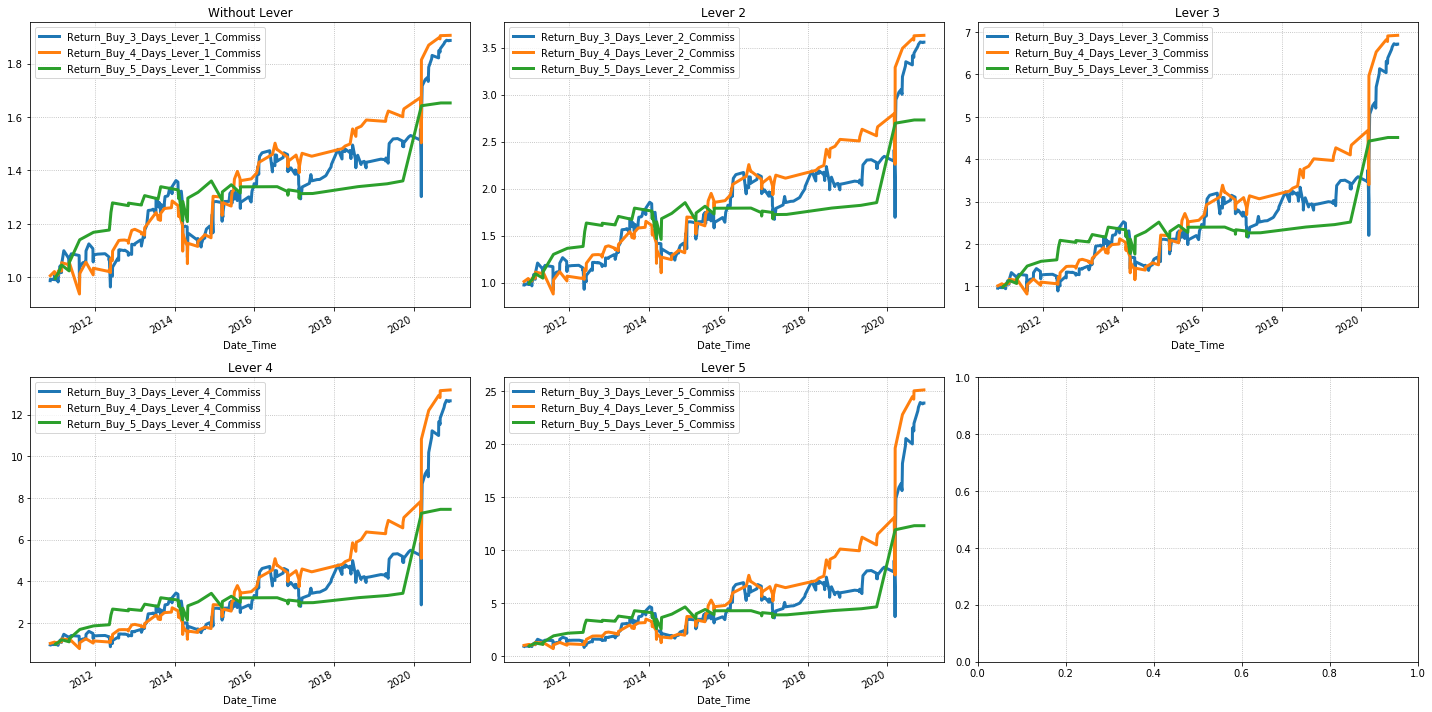

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
df[[
    #'Return_Buy_1_Days_Lever_1_Commiss',
    #'Return_Buy_2_Days_Lever_1_Commiss',
    'Return_Buy_3_Days_Lever_1_Commiss',
    'Return_Buy_4_Days_Lever_1_Commiss',
    'Return_Buy_5_Days_Lever_1_Commiss'
]].interpolate(method='index').plot(ax=ax[0,0], title='Without Lever')
df[[
    #'Return_Buy_1_Days_Lever_2_Commiss',
    #'Return_Buy_2_Days_Lever_2_Commiss',
    'Return_Buy_3_Days_Lever_2_Commiss',
    'Return_Buy_4_Days_Lever_2_Commiss',
    'Return_Buy_5_Days_Lever_2_Commiss'
]].interpolate(method='index').plot(ax=ax[0,1], title='Lever 2')
df[[
    #'Return_Buy_1_Days_Lever_3_Commiss',
    #'Return_Buy_2_Days_Lever_3_Commiss',
    'Return_Buy_3_Days_Lever_3_Commiss',
    'Return_Buy_4_Days_Lever_3_Commiss',
    'Return_Buy_5_Days_Lever_3_Commiss'
]].interpolate(method='index').plot(ax=ax[0,2], title='Lever 3')
df[[
    #'Return_Buy_1_Days_Lever_4_Commiss',
    #'Return_Buy_2_Days_Lever_4_Commiss',
    'Return_Buy_3_Days_Lever_4_Commiss',
    'Return_Buy_4_Days_Lever_4_Commiss',
    'Return_Buy_5_Days_Lever_4_Commiss'
]].interpolate(method='index').plot(ax=ax[1,0], title='Lever 4')
df[[
    #'Return_Buy_1_Days_Lever_5_Commiss',
    #'Return_Buy_2_Days_Lever_5_Commiss',
    'Return_Buy_3_Days_Lever_5_Commiss',
    'Return_Buy_4_Days_Lever_5_Commiss',
    'Return_Buy_5_Days_Lever_5_Commiss'
]].interpolate(method='index').plot(ax=ax[1,1], title='Lever 5')
plt.tight_layout()
plt.savefig('../src/buy_futures_sber_leverage.png')


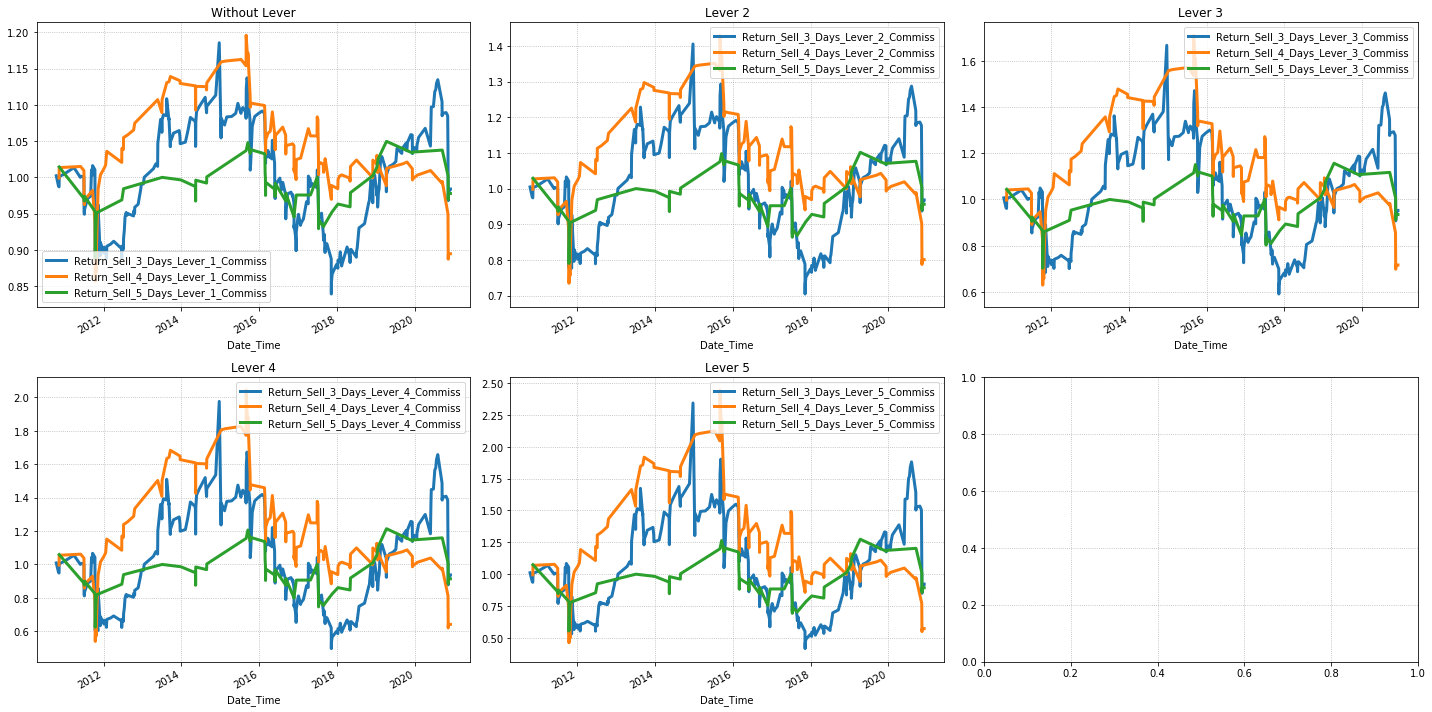

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
df[[
    #'Return_Sell_1_Days_Lever_1_Commiss',
    #'Return_Sell_2_Days_Lever_1_Commiss',
    'Return_Sell_3_Days_Lever_1_Commiss',
    'Return_Sell_4_Days_Lever_1_Commiss',
    'Return_Sell_5_Days_Lever_1_Commiss'
]].interpolate(method='index').plot(ax=ax[0,0], title='Without Lever')
df[[
    #'Return_Sell_1_Days_Lever_2_Commiss',
    #'Return_Sell_2_Days_Lever_2_Commiss',
    'Return_Sell_3_Days_Lever_2_Commiss',
    'Return_Sell_4_Days_Lever_2_Commiss',
    'Return_Sell_5_Days_Lever_2_Commiss'
]].interpolate(method='index').plot(ax=ax[0,1], title='Lever 2')
df[[
    #'Return_Sell_1_Days_Lever_3_Commiss',
    #'Return_Sell_2_Days_Lever_3_Commiss',
    'Return_Sell_3_Days_Lever_3_Commiss',
    'Return_Sell_4_Days_Lever_3_Commiss',
    'Return_Sell_5_Days_Lever_3_Commiss'
]].interpolate(method='index').plot(ax=ax[0,2], title='Lever 3')
df[[
    #'Return_Sell_1_Days_Lever_4_Commiss',
    #'Return_Sell_2_Days_Lever_4_Commiss',
    'Return_Sell_3_Days_Lever_4_Commiss',
    'Return_Sell_4_Days_Lever_4_Commiss',
    'Return_Sell_5_Days_Lever_4_Commiss'
]].interpolate(method='index').plot(ax=ax[1,0], title='Lever 4')
df[[
    #'Return_Sell_1_Days_Lever_5_Commiss',
    #'Return_Sell_2_Days_Lever_5_Commiss',
    'Return_Sell_3_Days_Lever_5_Commiss',
    'Return_Sell_4_Days_Lever_5_Commiss',
    'Return_Sell_5_Days_Lever_5_Commiss'
]].interpolate(method='index').plot(ax=ax[1,1], title='Lever 5')
plt.tight_layout()
plt.savefig('../src/sell_futures_sber_leverage.png')

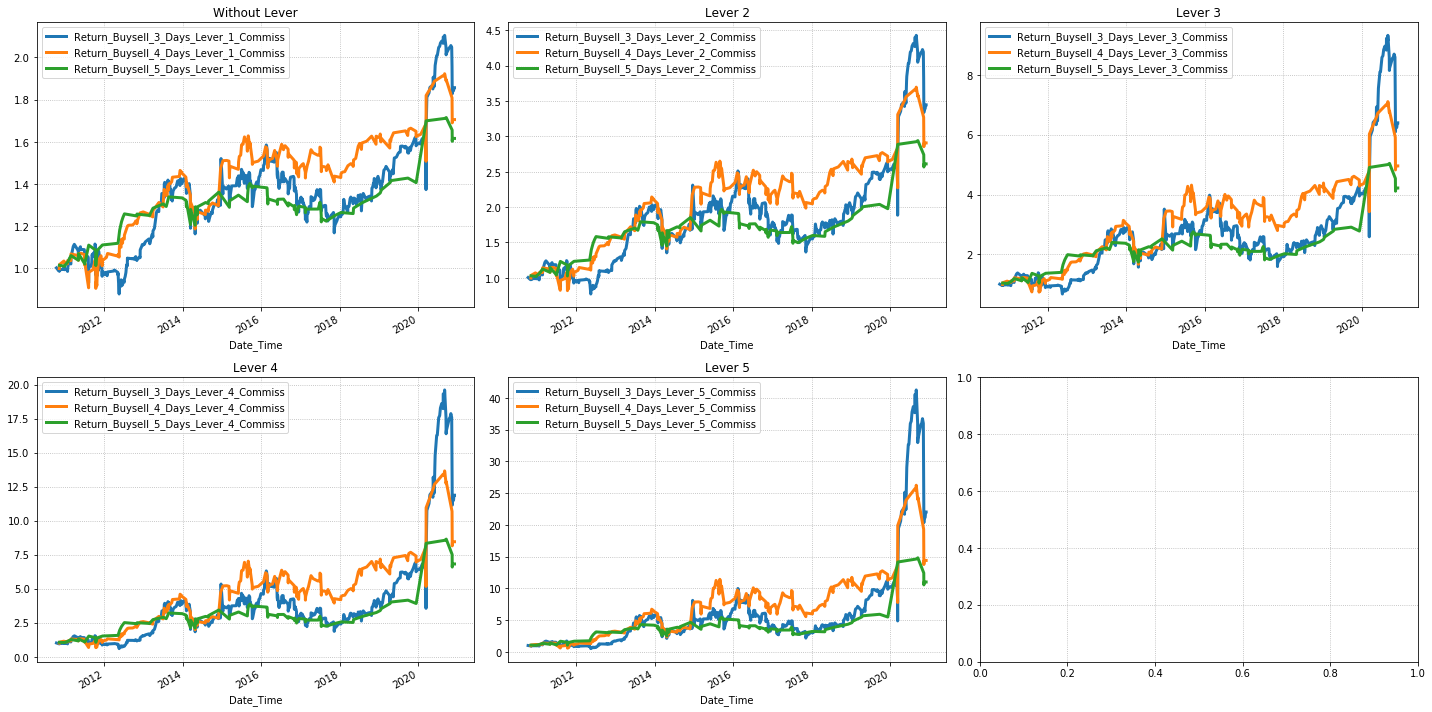

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
df[[
    #'Return_Buysell_1_Days_Lever_1_Commiss',
    #'Return_Buysell_2_Days_Lever_1_Commiss',
    'Return_Buysell_3_Days_Lever_1_Commiss',
    'Return_Buysell_4_Days_Lever_1_Commiss',
    'Return_Buysell_5_Days_Lever_1_Commiss'
]].interpolate(method='index').plot(ax=ax[0,0], title='Without Lever')
df[[
    #'Return_Buysell_1_Days_Lever_2_Commiss',
    #'Return_Buysell_2_Days_Lever_2_Commiss',
    'Return_Buysell_3_Days_Lever_2_Commiss',
    'Return_Buysell_4_Days_Lever_2_Commiss',
    'Return_Buysell_5_Days_Lever_2_Commiss'
]].interpolate(method='index').plot(ax=ax[0,1], title='Lever 2')
df[[
    #'Return_Buysell_1_Days_Lever_3_Commiss',
    #'Return_Buysell_2_Days_Lever_3_Commiss',
    'Return_Buysell_3_Days_Lever_3_Commiss',
    'Return_Buysell_4_Days_Lever_3_Commiss',
    'Return_Buysell_5_Days_Lever_3_Commiss'
]].interpolate(method='index').plot(ax=ax[0,2], title='Lever 3')
df[[
    #'Return_Buysell_1_Days_Lever_4_Commiss',
    #'Return_Buysell_2_Days_Lever_4_Commiss',
    'Return_Buysell_3_Days_Lever_4_Commiss',
    'Return_Buysell_4_Days_Lever_4_Commiss',
    'Return_Buysell_5_Days_Lever_4_Commiss'
]].interpolate(method='index').plot(ax=ax[1,0], title='Lever 4')
df[[
    #'Return_Buysell_1_Days_Lever_5_Commiss',
    #'Return_Buysell_2_Days_Lever_5_Commiss',
    'Return_Buysell_3_Days_Lever_5_Commiss',
    'Return_Buysell_4_Days_Lever_5_Commiss',
    'Return_Buysell_5_Days_Lever_5_Commiss'
]].interpolate(method='index').plot(ax=ax[1,1], title='Lever 5')
plt.tight_layout()
plt.savefig('../src/buysell_futures_sber_leverage.png')